# ResNet50 Model for report generatioin

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import os
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [5]:
# Dataset parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 20
DATA_DIR = '/home/ravindu/Documents/Projects/cnn-realwaste/realwaste/RealWaste'

CLASS_NAMES = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]


class WasteDataset(Dataset):
    """Custom Dataset for loading waste material images"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                image_files = sorted(class_dir.glob('*.*'))
                for img_path in image_files:
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label


def calculate_mean_std(dataset_path, image_size=224, sample_size=1000):
    """Calculate dataset mean and std for normalization"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=2)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    return mean.tolist(), std.tolist()


In [6]:
print("\n" + "="*70)
print("CALCULATING DATASET STATISTICS")
print("="*70)
dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)
print(f"Dataset Mean: {dataset_mean}")
print(f"Dataset Std: {dataset_std}")

# Data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.15),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.15)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

print("\n" + "="*70)
print("LOADING DATASET SPLITS")
print("="*70)

# Load the same split indices as the custom model
if not os.path.exists('split_indices.npz'):
    raise FileNotFoundError(
        "split_indices.npz not found! Please run the custom WasteNet model first "
        "to generate the split indices."
    )

print("✅ Loading split indices from split_indices.npz")
indices_file = np.load('split_indices.npz')
train_idx = indices_file['train']
val_idx = indices_file['val']
test_idx = indices_file['test']

print(f"  Train: {len(train_idx)} samples")
print(f"  Val:   {len(val_idx)} samples")
print(f"  Test:  {len(test_idx)} samples")

# Create datasets with transforms
full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
train_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=train_transform)
val_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)
test_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)
test_dataset = Subset(test_dataset_full, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, drop_last=False)

print(f"\n✅ DataLoaders created")

print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS")
print("="*70)

labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])
train_labels = labels[train_idx].tolist()
class_counts = Counter(train_labels)
total_train = len(train_labels)

class_weights = torch.tensor(
    [total_train / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)],
    dtype=torch.float32
).to(device)

print("\nClass weights:")
for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"  {name:20s}: {weight:.3f} (count: {class_counts[i]:3d})")

print("\n" + "="*70)
print("BUILDING RESNET50 MODEL")
print("="*70)

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# Move model to device
model = model.to(device)

print(f"✅ ResNet50 loaded and configured")
print(f"   Pre-trained on ImageNet")
print(f"   Modified final layer: {in_features} -> {NUM_CLASSES}")
print(f"   All layers trainable (fine-tuning)")



CALCULATING DATASET STATISTICS
Dataset Mean: [0.5958589315414429, 0.6181400418281555, 0.6327119469642639]
Dataset Std: [0.1614437848329544, 0.1623637080192566, 0.18791130185127258]

LOADING DATASET SPLITS
✅ Loading split indices from split_indices.npz
  Train: 3326 samples
  Val:   713 samples
  Test:  713 samples

✅ DataLoaders created

COMPUTING CLASS WEIGHTS

Class weights:
  Cardboard           : 1.144 (count: 323)
  Food Organics       : 1.283 (count: 288)
  Glass               : 1.257 (count: 294)
  Metal               : 0.668 (count: 553)
  Miscellaneous Trash : 1.068 (count: 346)
  Paper               : 1.056 (count: 350)
  Plastic             : 0.573 (count: 645)
  Textile Trash       : 1.665 (count: 222)
  Vegetation          : 1.212 (count: 305)

BUILDING RESNET50 MODEL


/home/ravindu/miniconda3/envs/ml-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ravindu/miniconda3/envs/ml-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet50 loaded and configured
   Pre-trained on ImageNet
   Modified final layer: 2048 -> 9
   All layers trainable (fine-tuning)


In [7]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=15,
    T_mult=1,
    eta_min=1e-6
)

print("✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights")
print("✅ Optimizer: AdamW (lr=0.001, weight_decay=1e-4)")
print("✅ Scheduler: CosineAnnealingWarmRestarts (T_0=15)")


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


TRAINING CONFIGURATION
✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights
✅ Optimizer: AdamW (lr=0.001, weight_decay=1e-4)
✅ Scheduler: CosineAnnealingWarmRestarts (T_0=15)



STARTING TRAINING
Epoch [ 1/20] (33.8s) | LR: 0.000989 | Train Loss: 1.7254 | Train Acc: 43.02% | Val Loss: 1.5540 | Val Acc: 52.59% ✨ BEST!
Epoch [ 2/20] (33.0s) | LR: 0.000957 | Train Loss: 1.4632 | Train Acc: 55.50% | Val Loss: 1.4695 | Val Acc: 60.73% ✨ BEST!
Epoch [ 3/20] (33.2s) | LR: 0.000905 | Train Loss: 1.3419 | Train Acc: 60.49% | Val Loss: 1.3200 | Val Acc: 64.52% ✨ BEST!
Epoch [ 4/20] (33.2s) | LR: 0.000835 | Train Loss: 1.2658 | Train Acc: 64.55% | Val Loss: 1.1864 | Val Acc: 67.18% ✨ BEST!
Epoch [ 5/20] (33.3s) | LR: 0.000750 | Train Loss: 1.2024 | Train Acc: 67.29% | Val Loss: 1.0892 | Val Acc: 75.60% ✨ BEST!
Epoch [ 6/20] (33.4s) | LR: 0.000655 | Train Loss: 1.1259 | Train Acc: 71.20% | Val Loss: 1.0625 | Val Acc: 75.32%
Epoch [ 7/20] (33.4s) | LR: 0.000553 | Train Loss: 1.0569 | Train Acc: 74.68% | Val Loss: 1.0275 | Val Acc: 77.28% ✨ BEST!
Epoch [ 8/20] (33.4s) | LR: 0.000448 | Train Loss: 1.0058 | Train Acc: 78.29% | Val Loss: 1.0323 | Val Acc: 76.72%
Epoch [ 9/20]

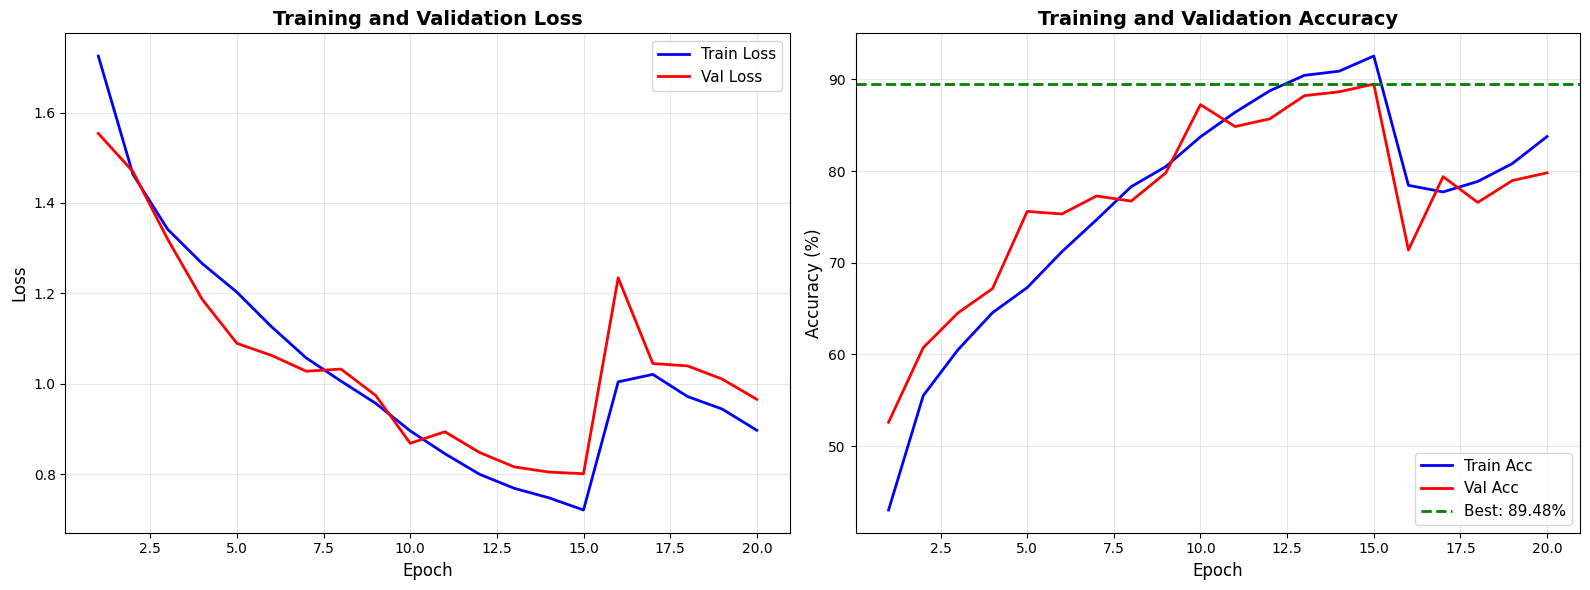

✅ Training curves saved to resnet50_training_curves.png

EVALUATING ON TRAINING AND TEST SETS

📊 Training Set Evaluation:
  Accuracy:  94.71%
  Precision: 0.9458
  Recall:    0.9548
  F1-Score:  0.9498

📊 Test Set Evaluation:
  Accuracy:  89.76%
  Precision: 0.9042
  Recall:    0.9080
  F1-Score:  0.9060

GENERATING CONFUSION MATRIX


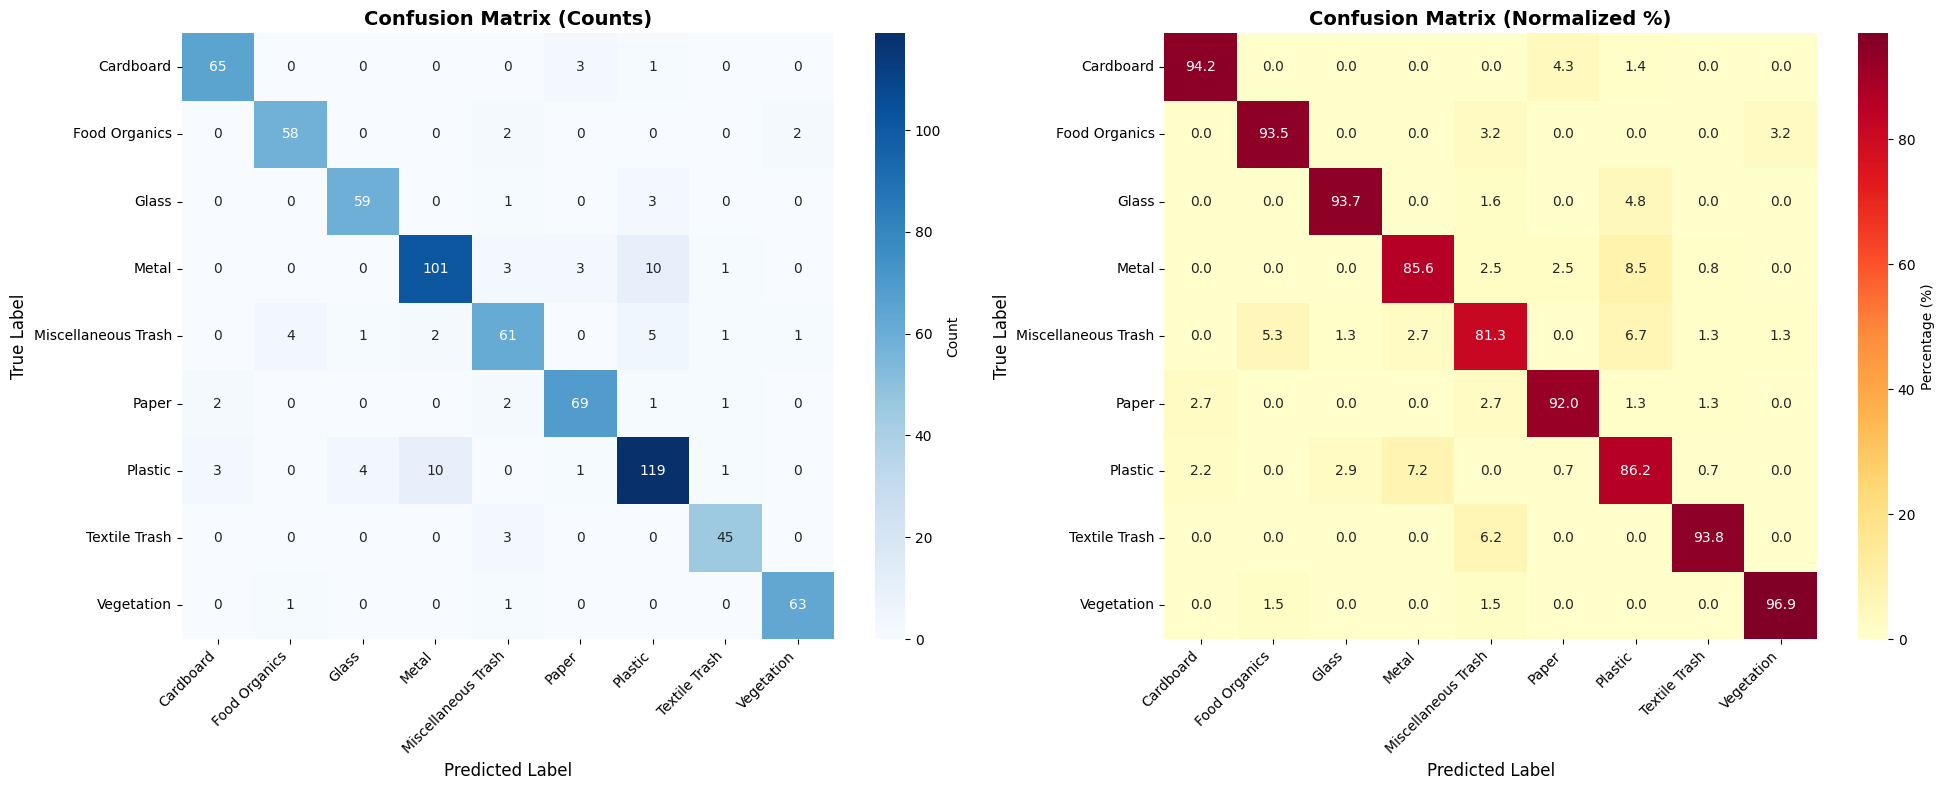

✅ Confusion matrix saved to resnet50_confusion_matrix.png

📊 Per-Class Accuracy:
  Cardboard           : 94.20% (65/69)
  Food Organics       : 93.55% (58/62)
  Glass               : 93.65% (59/63)
  Metal               : 85.59% (101/118)
  Miscellaneous Trash : 81.33% (61/75)
  Paper               : 92.00% (69/75)
  Plastic             : 86.23% (119/138)
  Textile Trash       : 93.75% (45/48)
  Vegetation          : 96.92% (63/65)

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard     0.9286    0.9420    0.9353        69
      Food Organics     0.9206    0.9355    0.9280        62
              Glass     0.9219    0.9365    0.9291        63
              Metal     0.8938    0.8559    0.8745       118
Miscellaneous Trash     0.8356    0.8133    0.8243        75
              Paper     0.9079    0.9200    0.9139        75
            Plastic     0.8561    0.8623    0.8592       138
      Textile Trash     0.9184    0.9375    0.9278  

In [8]:
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = 100 * np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }


print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print progress
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] ({epoch_time:4.1f}s) | "
          f"LR: {current_lr:.6f} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}%", end='')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, 'best_resnet50.pth')
        print(" ✨ BEST!", end='')

    print()

total_time = time.time() - start_time

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"⏱️  Total time: {total_time/60:.1f} min")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📍 Best epoch: {best_epoch}")
print(f"💾 Model saved: best_resnet50.pth")

print("\n" + "="*70)
print("PLOTTING TRAINING CURVES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, len(history['train_loss']) + 1)

# Plot Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--',
               label=f'Best: {best_val_acc:.2f}%', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved to resnet50_training_curves.png")

print("\n" + "="*70)
print("EVALUATING ON TRAINING AND TEST SETS")
print("="*70)

# Load best model
checkpoint = torch.load('best_resnet50.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on training set
print("\n📊 Training Set Evaluation:")
train_metrics = evaluate_model(model, train_loader, device)
print(f"  Accuracy:  {train_metrics['accuracy']:.2f}%")
print(f"  Precision: {train_metrics['precision']:.4f}")
print(f"  Recall:    {train_metrics['recall']:.4f}")
print(f"  F1-Score:  {train_metrics['f1']:.4f}")

# Evaluate on test set
print("\n📊 Test Set Evaluation:")
test_metrics = evaluate_model(model, test_loader, device)
print(f"  Accuracy:  {test_metrics['accuracy']:.2f}%")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")

print("\n" + "="*70)
print("GENERATING CONFUSION MATRIX")
print("="*70)

cm = test_metrics['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='YlOrRd',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved to resnet50_confusion_matrix.png")

print("\n📊 Per-Class Accuracy:")
for i, class_name in enumerate(CLASS_NAMES):
    accuracy = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {accuracy:5.2f}% ({cm[i, i]}/{cm[i].sum()})")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(test_metrics['labels'], test_metrics['predictions'], 
                          target_names=CLASS_NAMES, digits=4))

print("\n" + "="*70)
print("RESNET50 EVALUATION COMPLETE")
print("="*70)
print(f"✅ Train Accuracy: {train_metrics['accuracy']:.2f}%")
print(f"✅ Test Accuracy:  {test_metrics['accuracy']:.2f}%")
print(f"✅ Test Precision: {test_metrics['precision']:.4f}")
print(f"✅ Test Recall:    {test_metrics['recall']:.4f}")
print(f"✅ Test F1-Score:  {test_metrics['f1']:.4f}")
print("="*70)